# Problem 1 - Principal Component Analysis

## Problem 1.1 - PCA

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import plotly.express as px
from sklearn import metrics as sm
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier as KNN_sk

In [2]:
cfw_dict = {
    'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7
}

opt = {
    'image_size': 32,
    'is_grayscale': False,
    'val_split': 0.75
}

In [3]:
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

def display_images(imgs,classes,row=1,col=2,w=32,h=32):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

def load_data(dir_path):
    image_list = []
    y_list = []
    label_dict = cfw_dict
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue
    image_list = np.array(image_list)
    y_list = np.array(y_list)
    print("Dataset shape:",image_list.shape)
    print("Label shape:",y_list.shape)

    return image_list,y_list

In [4]:
dirpath = './Data/PCA/IIIT-CFW/'
X,y = load_data(dirpath)

# Shuffling X and y in the same order
shuffling_indices = np.random.permutation(X.shape[0])
X = X[shuffling_indices]
y = y[shuffling_indices]

Dataset shape: (672, 32, 32, 3)
Label shape: (672,)


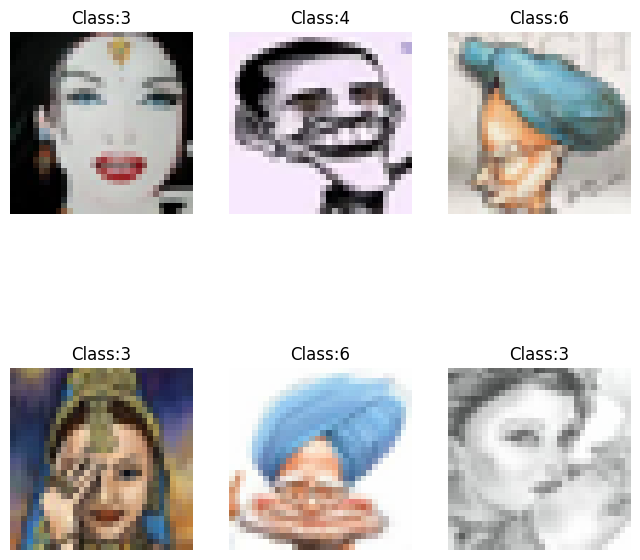

In [5]:
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]

ind = np.random.randint(0,y.shape[0],6)
display_images(X[ind,...],y[ind], row=2,col=3)

### Problem 1.1.1 - Dimensionality reduction on IIIT-CFW dataset

In [6]:
class PCA():
    def __init__(self):
        self.data_dim   =   (None, None, None, None)
        self.new_dim    =   (None, None)
        self.X_new      =   None
        self.P          =   None
        self.row_means  =   None
        self.variances  =   None
        self.num_principal_components = 1
        self.X_transformed  = None
        self.X_compressed   = None
    
    def set_num_principal_components(self, num_principal_components):
        self.num_principal_components = min(num_principal_components, self.X_new.shape[0])
    
    def fit(self, X):
        """
        Perform PCA on the given data and obtain the principal components along with the variances
        """
        self.data_dim = X.shape                     # (672, 32, 32, 3)
        self.new_dim  = (self.data_dim[0], -1)      # (672, 3072)
        
        self.X_new = np.reshape(X, self.new_dim).T  # (3072, 672)

        self.row_means = np.mean(self.X_new, axis=1)[:, None]
        self.X_new -= self.row_means

        C_X = (self.X_new @ self.X_new.T) / (self.X_new.shape[1] - 1)   # Covariance matrix with dimensions (3072, 3072)
        eigValues, eigVectors = np.linalg.eigh(C_X)

        eigValues  = np.array(np.array(eigValues, dtype=np.float16), dtype=np.float64)
        eigVectors = np.array(np.array(eigVectors, dtype=np.float16), dtype=np.float64)

        sortedIndices = np.argsort(eigValues)[::-1]     # Sorting eigenvalues and eigenvectors in descending order
                                                        # of the eigenvalues
        eigValues  = eigValues[sortedIndices]
        eigVectors = eigVectors[:, sortedIndices]

        self.P = eigVectors.T               # Projection matrix - (3072, 3072)
        self.variances = eigValues ** 2     # 3072 values
    
    def transform(self):
        """
        Transform the data to the new basis
        """
        self.X_transformed = self.P[:self.num_principal_components, :] @ self.X_new     # (num_principal_components, 672)
        self.X_transformed = (self.X_transformed + self.row_means[:self.num_principal_components, :]).T
    
    def compress(self):
        """
        Compress the data by reconstructing it to the old basis but from the reduced basis
        """
        self.X_compressed = self.P[:self.num_principal_components, :].T @ self.P[:self.num_principal_components, :] @ self.X_new
        self.X_compressed = (self.X_compressed + self.row_means).T  # (3072, 672).T = (672, 3072)

        self.X_compressed = np.reshape(self.X_compressed, self.data_dim)    # (672, 32, 32, 3)

In [7]:
PCA_reducer = PCA()
PCA_reducer.fit(X)

### Problem 1.1.2 - Cumulative explained variance vs Number of principal components

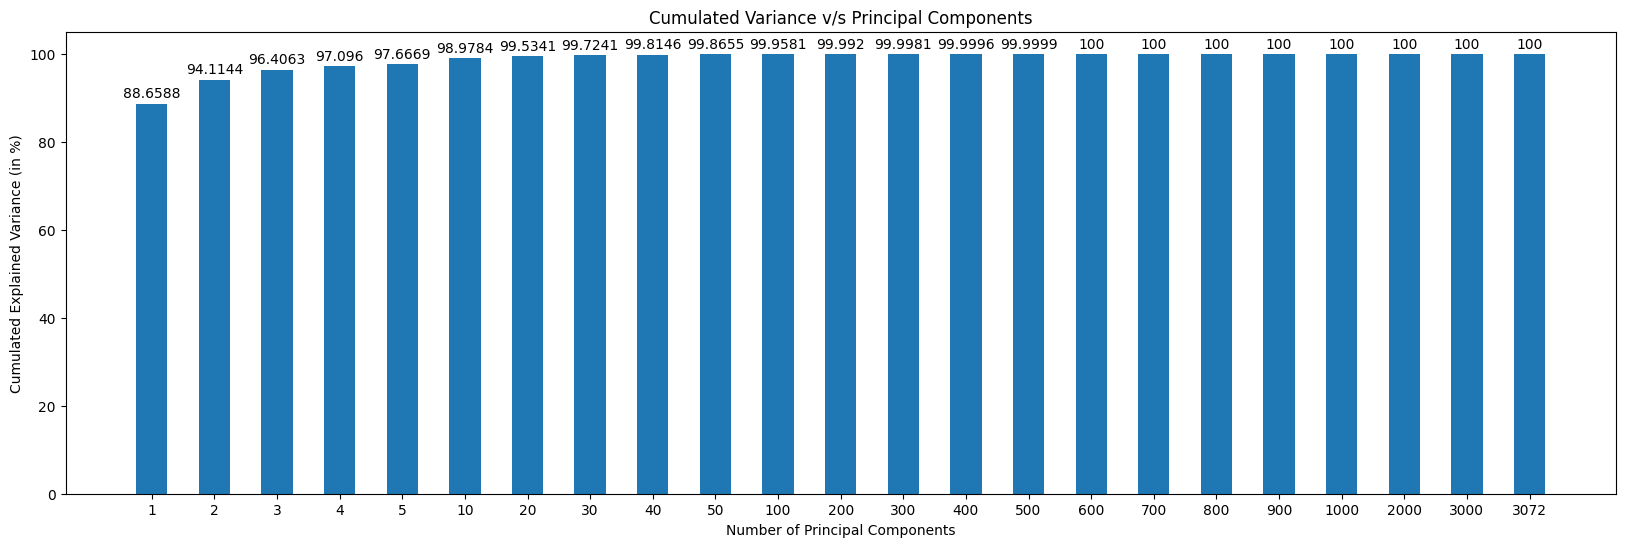

In [8]:
variance_indices = [1, 2, 3, 4, 5]

for i in range(10, 60, 10):
    variance_indices.append(i)
for i in range(100, 1000, 100):
    variance_indices.append(i)
variance_indices += [1000, 2000, 3000, 3072]

cumulative_explained_variances = np.array([np.sum(PCA_reducer.variances[:i]) for i in variance_indices])
percent_cumulative_explained_variances = cumulative_explained_variances * 100 / np.sum(PCA_reducer.variances)

plt.figure(figsize=(20, 6))

bars = plt.bar([str(i) for i in variance_indices], percent_cumulative_explained_variances, width=0.5, label=percent_cumulative_explained_variances)
plt.bar_label(bars, padding=2)

plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulated Explained Variance (in %)')
plt.title('Cumulated Variance v/s Principal Components')
plt.show()

#### Problem 1.1.1 - Demonstration of Image Compression Using PCA

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


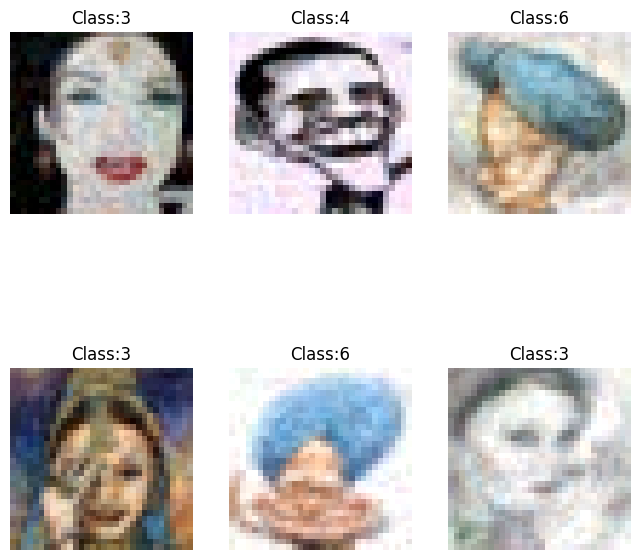

In [9]:
PCA_reducer.set_num_principal_components(256)
PCA_reducer.compress()
display_images(PCA_reducer.X_compressed[ind,...],y[ind], row=2,col=3)

# Due to the floating point computation errors, the pixel values cross the range and are truncated to fit the permissible values of image pixels

### Problem 1.1.3 - Dimensionality reduction on Assignment 1 pictionary dataset

In [10]:
pictionary_data = np.load("./Data/PCA/Pictionary/a1_data.npy", allow_pickle=True)
pictionary_data = pictionary_data[:, 1:4]
np.random.shuffle(pictionary_data)

pictionary_data_ResNet = np.array([np.array(i) for i in pictionary_data[:, 0]])
pictionary_data_VIT    = np.array([np.array(i) for i in pictionary_data[:, 1]])
pictionary_data_labels = np.array([np.array(i) for i in pictionary_data[:, 2]])

#### ResNet metrics before performing PCA

In [11]:
temp_pictionary_data_ResNet = np.reshape(pictionary_data_ResNet, (pictionary_data_ResNet.shape[0], -1))

pre_PCA_train_ResNet = temp_pictionary_data_ResNet[:int(pictionary_data_ResNet.shape[0] * opt['val_split']) ]
pre_PCA_test_ResNet  = temp_pictionary_data_ResNet[ int(pictionary_data_ResNet.shape[0] * opt['val_split']):]

PCA_train_labels_ResNet = pictionary_data_labels[:int(pictionary_data_ResNet.shape[0] * opt['val_split']) ]
PCA_test_labels_ResNet  = pictionary_data_labels[ int(pictionary_data_ResNet.shape[0] * opt['val_split']):]

pre_PCA_KNN_ResNet = KNN_sk()
pre_PCA_KNN_ResNet.fit(pre_PCA_train_ResNet, PCA_train_labels_ResNet)

pre_PCA_predictions_ResNet  = pre_PCA_KNN_ResNet.predict(pre_PCA_test_ResNet)

pre_PCA_accuracy_ResNet            = sm.accuracy_score( PCA_test_labels_ResNet, pre_PCA_predictions_ResNet)
pre_PCA_macro_f1_score_ResNet      = sm.f1_score(       PCA_test_labels_ResNet, pre_PCA_predictions_ResNet, average='macro')
pre_PCA_micro_f1_score_ResNet      = sm.f1_score(       PCA_test_labels_ResNet, pre_PCA_predictions_ResNet, average='micro')
pre_PCA_weighted_f1_score_ResNet   = sm.f1_score(       PCA_test_labels_ResNet, pre_PCA_predictions_ResNet, average='weighted')
pre_PCA_precision_ResNet           = sm.precision_score(PCA_test_labels_ResNet, pre_PCA_predictions_ResNet, average='macro', zero_division=0)
pre_PCA_recall_ResNet              = sm.recall_score(   PCA_test_labels_ResNet, pre_PCA_predictions_ResNet, average='macro', zero_division=0)

#### Metrics after performing PCA on ResNet encodings by varying number of features

In [12]:
ResNet_pca_metrics = []

num_features_ResNet = [1, 2, 3, 4, 5]
for i in range(10, 110, 10):
    num_features_ResNet.append(i)
for i in range(150, 550, 50):
    num_features_ResNet.append(i)
for i in range(600, 1100, 100):
    num_features_ResNet.append(i)
num_features_ResNet.append(1024)

for i in num_features_ResNet:
    ResNet_PCA_Reducer = PCA()
    ResNet_PCA_Reducer.fit(pictionary_data_ResNet)

    ResNet_PCA_Reducer.set_num_principal_components(i)
    ResNet_PCA_Reducer.transform()

    post_PCA_train_ResNet = ResNet_PCA_Reducer.X_transformed[:int(ResNet_PCA_Reducer.X_transformed.shape[0] * opt['val_split']) ]
    post_PCA_test_ResNet  = ResNet_PCA_Reducer.X_transformed[ int(ResNet_PCA_Reducer.X_transformed.shape[0] * opt['val_split']):]

    post_PCA_KNN_ResNet = KNN_sk()
    post_PCA_KNN_ResNet.fit(post_PCA_train_ResNet, PCA_train_labels_ResNet)

    post_PCA_predictions_ResNet = post_PCA_KNN_ResNet.predict(post_PCA_test_ResNet)

    post_PCA_accuracy_ResNet           = sm.accuracy_score( PCA_test_labels_ResNet, post_PCA_predictions_ResNet)
    post_PCA_macro_f1_score_ResNet     = sm.f1_score(       PCA_test_labels_ResNet, post_PCA_predictions_ResNet, average='macro')
    post_PCA_micro_f1_score_ResNet     = sm.f1_score(       PCA_test_labels_ResNet, post_PCA_predictions_ResNet, average='micro')
    post_PCA_weighted_f1_score_ResNet  = sm.f1_score(       PCA_test_labels_ResNet, post_PCA_predictions_ResNet, average='weighted')
    post_PCA_precision_ResNet          = sm.precision_score(PCA_test_labels_ResNet, post_PCA_predictions_ResNet, average='macro', zero_division=0)
    post_PCA_recall_ResNet             = sm.recall_score(   PCA_test_labels_ResNet, post_PCA_predictions_ResNet, average='macro', zero_division=0)

    ResNet_pca_metrics.append([post_PCA_accuracy_ResNet, post_PCA_precision_ResNet, post_PCA_recall_ResNet, post_PCA_macro_f1_score_ResNet, post_PCA_micro_f1_score_ResNet, post_PCA_weighted_f1_score_ResNet])

#### Plots of ResNet features

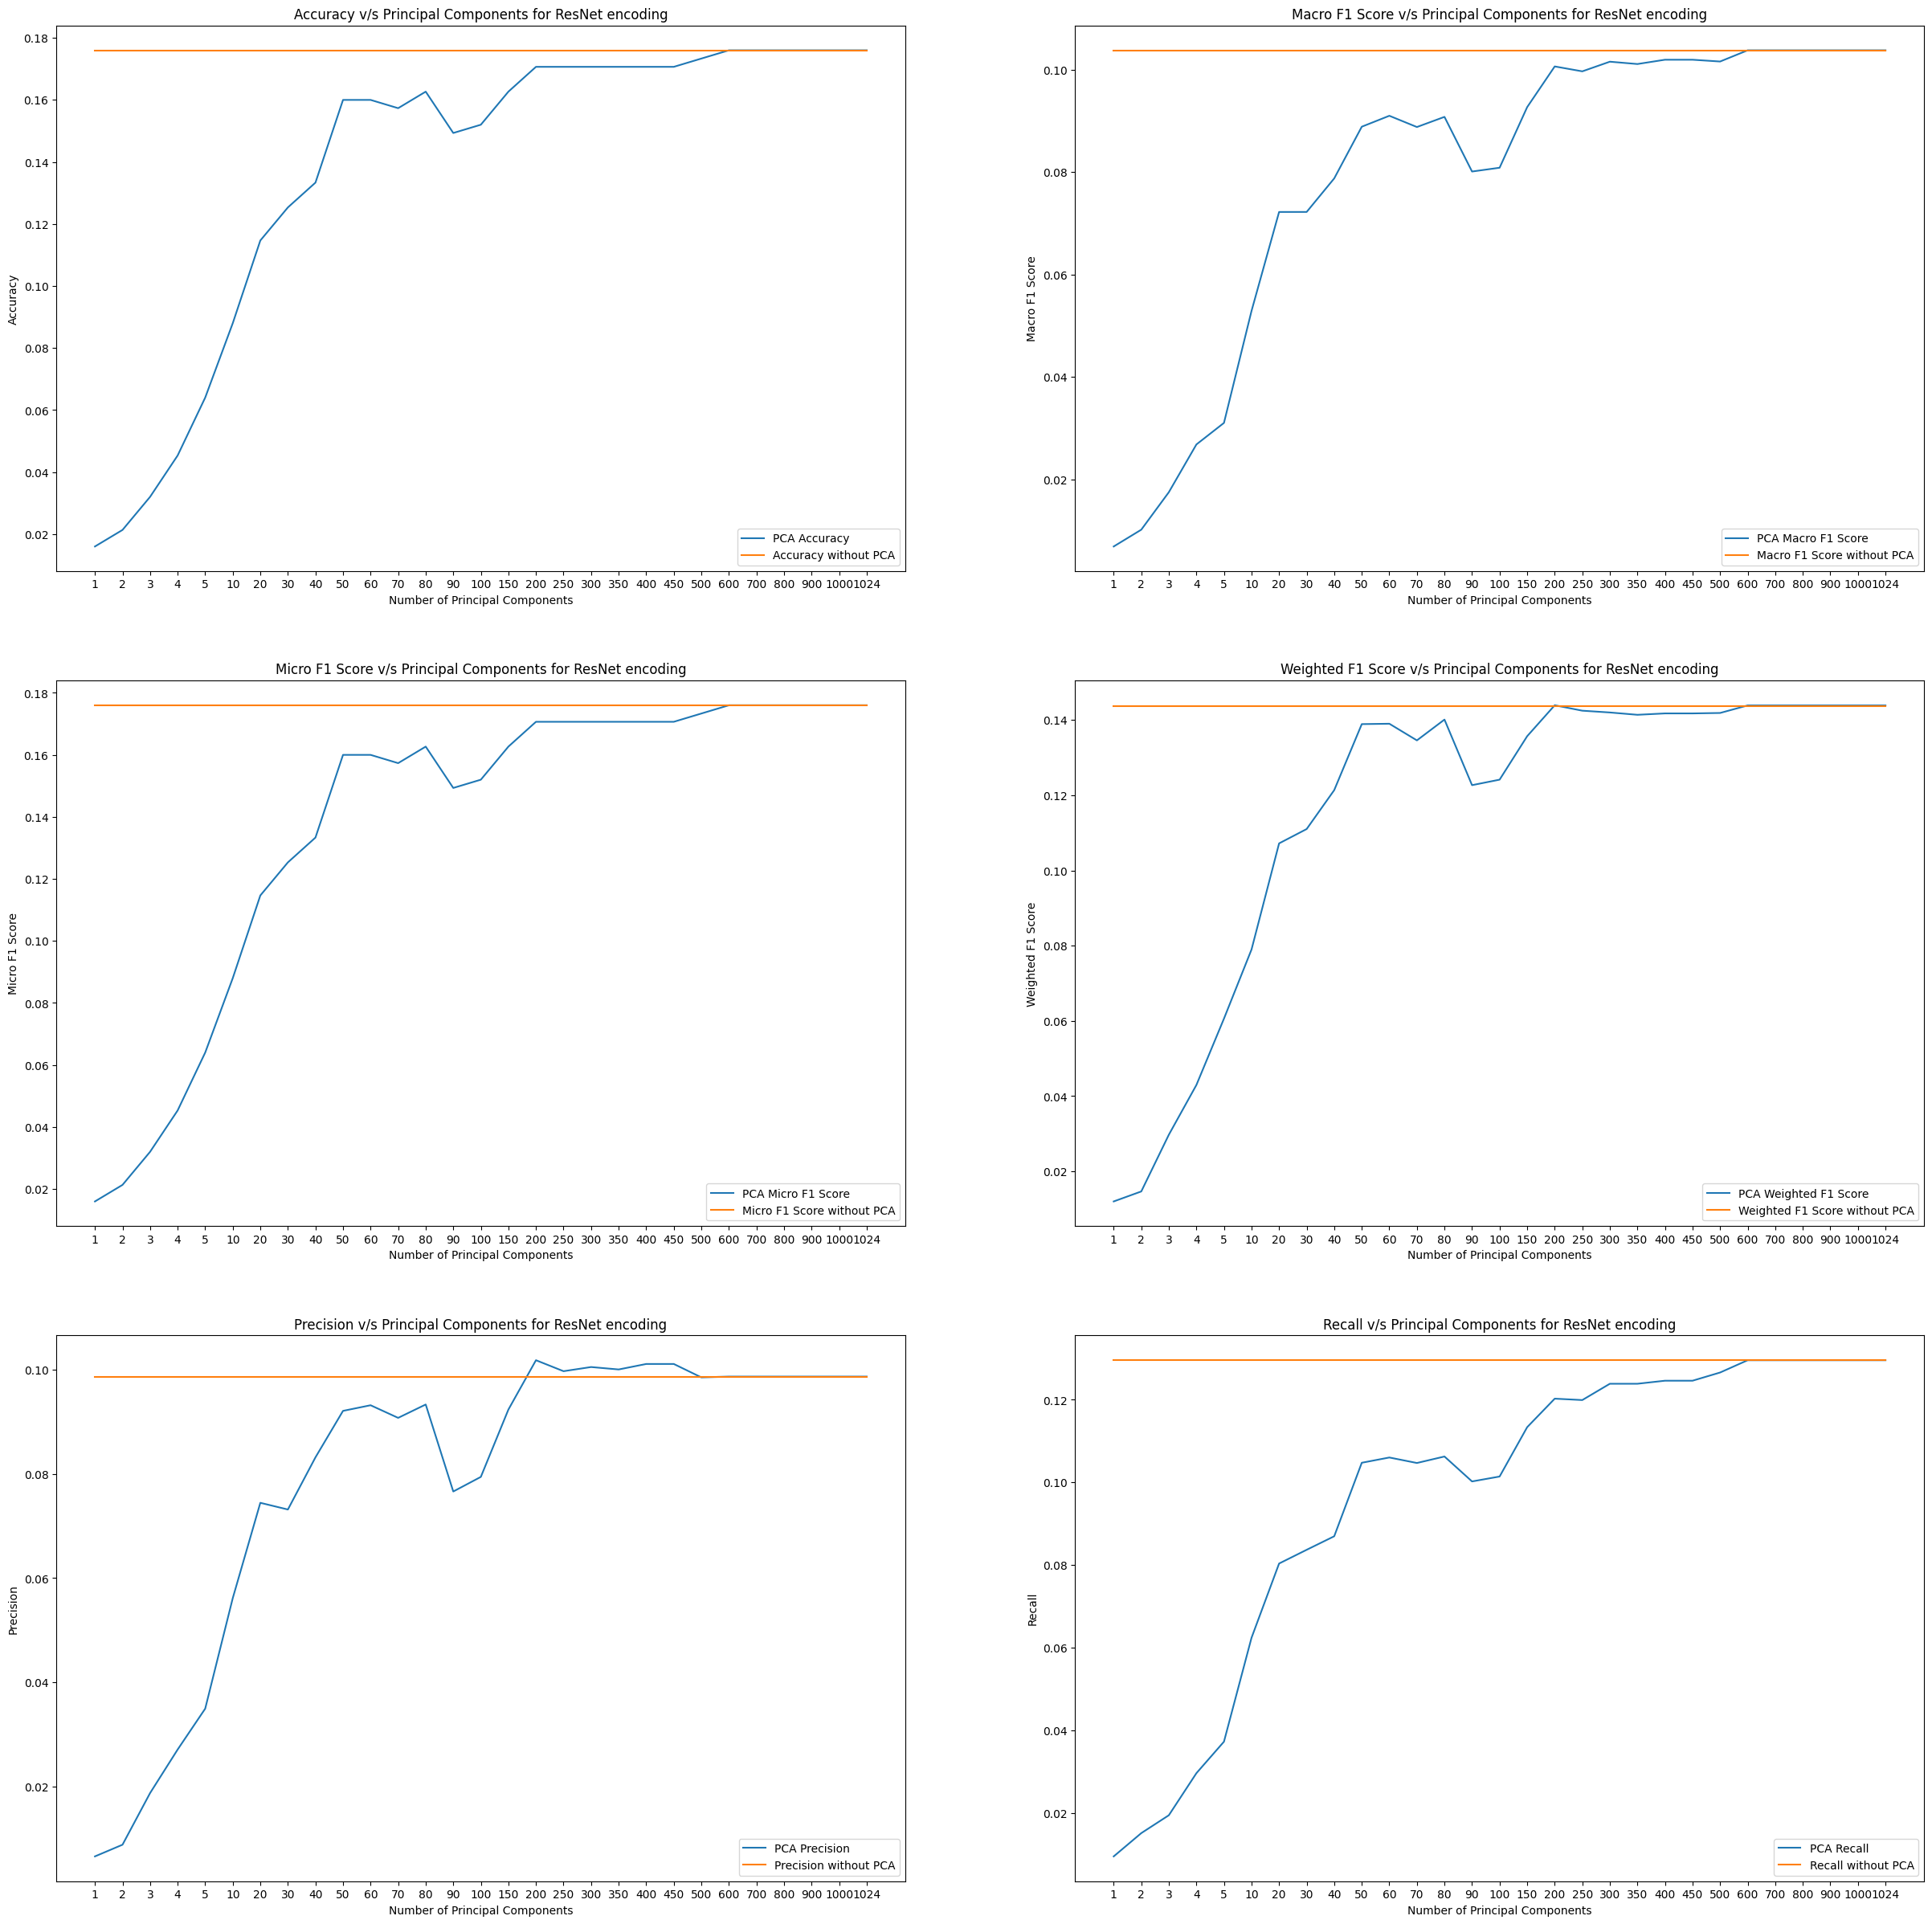

In [13]:
fig, axs = plt.subplots(3, 2, figsize=(30, 30))

axs[0, 0].plot([str(i) for i in num_features_ResNet], np.array(ResNet_pca_metrics)[:, 0], label='PCA Accuracy')
axs[0, 0].plot([str(i) for i in num_features_ResNet], np.full(len(num_features_ResNet), pre_PCA_accuracy_ResNet), label='Accuracy without PCA')

axs[0, 1].plot([str(i) for i in num_features_ResNet], np.array(ResNet_pca_metrics)[:, 3], label='PCA Macro F1 Score')
axs[0, 1].plot([str(i) for i in num_features_ResNet], np.full(len(num_features_ResNet), pre_PCA_macro_f1_score_ResNet), label='Macro F1 Score without PCA')

axs[1, 0].plot([str(i) for i in num_features_ResNet], np.array(ResNet_pca_metrics)[:, 4], label='PCA Micro F1 Score')
axs[1, 0].plot([str(i) for i in num_features_ResNet], np.full(len(num_features_ResNet), pre_PCA_micro_f1_score_ResNet), label='Micro F1 Score without PCA')

axs[1, 1].plot([str(i) for i in num_features_ResNet], np.array(ResNet_pca_metrics)[:, 5], label='PCA Weighted F1 Score')
axs[1, 1].plot([str(i) for i in num_features_ResNet], np.full(len(num_features_ResNet), pre_PCA_weighted_f1_score_ResNet), label='Weighted F1 Score without PCA')

axs[2, 0].plot([str(i) for i in num_features_ResNet], np.array(ResNet_pca_metrics)[:, 1], label='PCA Precision')
axs[2, 0].plot([str(i) for i in num_features_ResNet], np.full(len(num_features_ResNet), pre_PCA_precision_ResNet), label='Precision without PCA')

axs[2, 1].plot([str(i) for i in num_features_ResNet], np.array(ResNet_pca_metrics)[:, 2], label='PCA Recall')
axs[2, 1].plot([str(i) for i in num_features_ResNet], np.full(len(num_features_ResNet), pre_PCA_recall_ResNet), label='Recall without PCA')

metrics = ['Accuracy', 'Macro F1 Score', 'Micro F1 Score', 'Weighted F1 Score', 'Precision', 'Recall']
for i in range(3):
    for j in range(2):
        axs[i, j].set_xlabel('Number of Principal Components')
        axs[i, j].set_ylabel(metrics[i * 2 + j])
        axs[i, j].set_title(str(metrics[i * 2 + j]) + ' v/s Principal Components for ResNet encoding')
        axs[i, j].legend()

plt.show()

- #### As we can observe, as we keep on increasing the number of features of the ResNet encodings, the metrics get better and even become better than the values we obtain without performing PCA
- #### But as we further increase the number of components considered, PCA converges to the case of no PCA, as expected, because we are considering all the components to represent the image

#### VIT metrics before PCA

In [14]:
temp_pictionary_data_VIT = np.reshape(pictionary_data_VIT, (pictionary_data_VIT.shape[0], -1))

pre_PCA_train_VIT = temp_pictionary_data_VIT[:int(pictionary_data_VIT.shape[0] * opt['val_split']) ]
pre_PCA_test_VIT  = temp_pictionary_data_VIT[ int(pictionary_data_VIT.shape[0] * opt['val_split']):]

PCA_train_labels_VIT = pictionary_data_labels[:int(pictionary_data_VIT.shape[0] * opt['val_split']) ]
PCA_test_labels_VIT  = pictionary_data_labels[ int(pictionary_data_VIT.shape[0] * opt['val_split']):]

pre_PCA_KNN_VIT = KNN_sk()
pre_PCA_KNN_VIT.fit(pre_PCA_train_VIT, PCA_train_labels_VIT)

pre_PCA_predictions_VIT  = pre_PCA_KNN_VIT.predict(pre_PCA_test_VIT)

pre_PCA_accuracy_VIT            = sm.accuracy_score( PCA_test_labels_VIT, pre_PCA_predictions_VIT)
pre_PCA_macro_f1_score_VIT      = sm.f1_score(       PCA_test_labels_VIT, pre_PCA_predictions_VIT, average='macro')
pre_PCA_micro_f1_score_VIT      = sm.f1_score(       PCA_test_labels_VIT, pre_PCA_predictions_VIT, average='micro')
pre_PCA_weighted_f1_score_VIT   = sm.f1_score(       PCA_test_labels_VIT, pre_PCA_predictions_VIT, average='weighted')
pre_PCA_precision_VIT           = sm.precision_score(PCA_test_labels_VIT, pre_PCA_predictions_VIT, average='macro', zero_division=0)
pre_PCA_recall_VIT              = sm.recall_score(   PCA_test_labels_VIT, pre_PCA_predictions_VIT, average='macro', zero_division=0)

#### Metrics after performing PCA on VIT encodings by varying number of features

In [15]:
VIT_pca_metrics = []

num_features_VIT = [1, 2, 3, 4, 5]
for i in range(10, 110, 10):
    num_features_VIT.append(i)
for i in range(150, 550, 50):
    num_features_VIT.append(i)
num_features_VIT.append(512)

for i in num_features_VIT:
    VIT_PCA_Reducer = PCA()
    VIT_PCA_Reducer.fit(pictionary_data_VIT)

    VIT_PCA_Reducer.set_num_principal_components(i)
    VIT_PCA_Reducer.transform()

    post_PCA_train_VIT = VIT_PCA_Reducer.X_transformed[:int(VIT_PCA_Reducer.X_transformed.shape[0] * opt['val_split']) ]
    post_PCA_test_VIT  = VIT_PCA_Reducer.X_transformed[ int(VIT_PCA_Reducer.X_transformed.shape[0] * opt['val_split']):]

    post_PCA_KNN_VIT = KNN_sk()
    post_PCA_KNN_VIT.fit(post_PCA_train_VIT, PCA_train_labels_VIT)

    post_PCA_predictions_VIT = post_PCA_KNN_VIT.predict(post_PCA_test_VIT)

    post_PCA_accuracy_VIT           = sm.accuracy_score( PCA_test_labels_VIT, post_PCA_predictions_VIT)
    post_PCA_macro_f1_score_VIT     = sm.f1_score(       PCA_test_labels_VIT, post_PCA_predictions_VIT, average='macro')
    post_PCA_micro_f1_score_VIT     = sm.f1_score(       PCA_test_labels_VIT, post_PCA_predictions_VIT, average='micro')
    post_PCA_weighted_f1_score_VIT  = sm.f1_score(       PCA_test_labels_VIT, post_PCA_predictions_VIT, average='weighted')
    post_PCA_precision_VIT          = sm.precision_score(PCA_test_labels_VIT, post_PCA_predictions_VIT, average='macro', zero_division=0)
    post_PCA_recall_VIT             = sm.recall_score(   PCA_test_labels_VIT, post_PCA_predictions_VIT, average='macro', zero_division=0)

    VIT_pca_metrics.append([post_PCA_accuracy_VIT, post_PCA_precision_VIT, post_PCA_recall_VIT, post_PCA_macro_f1_score_VIT, post_PCA_micro_f1_score_VIT, post_PCA_weighted_f1_score_VIT])

#### Plots of VIT metrics

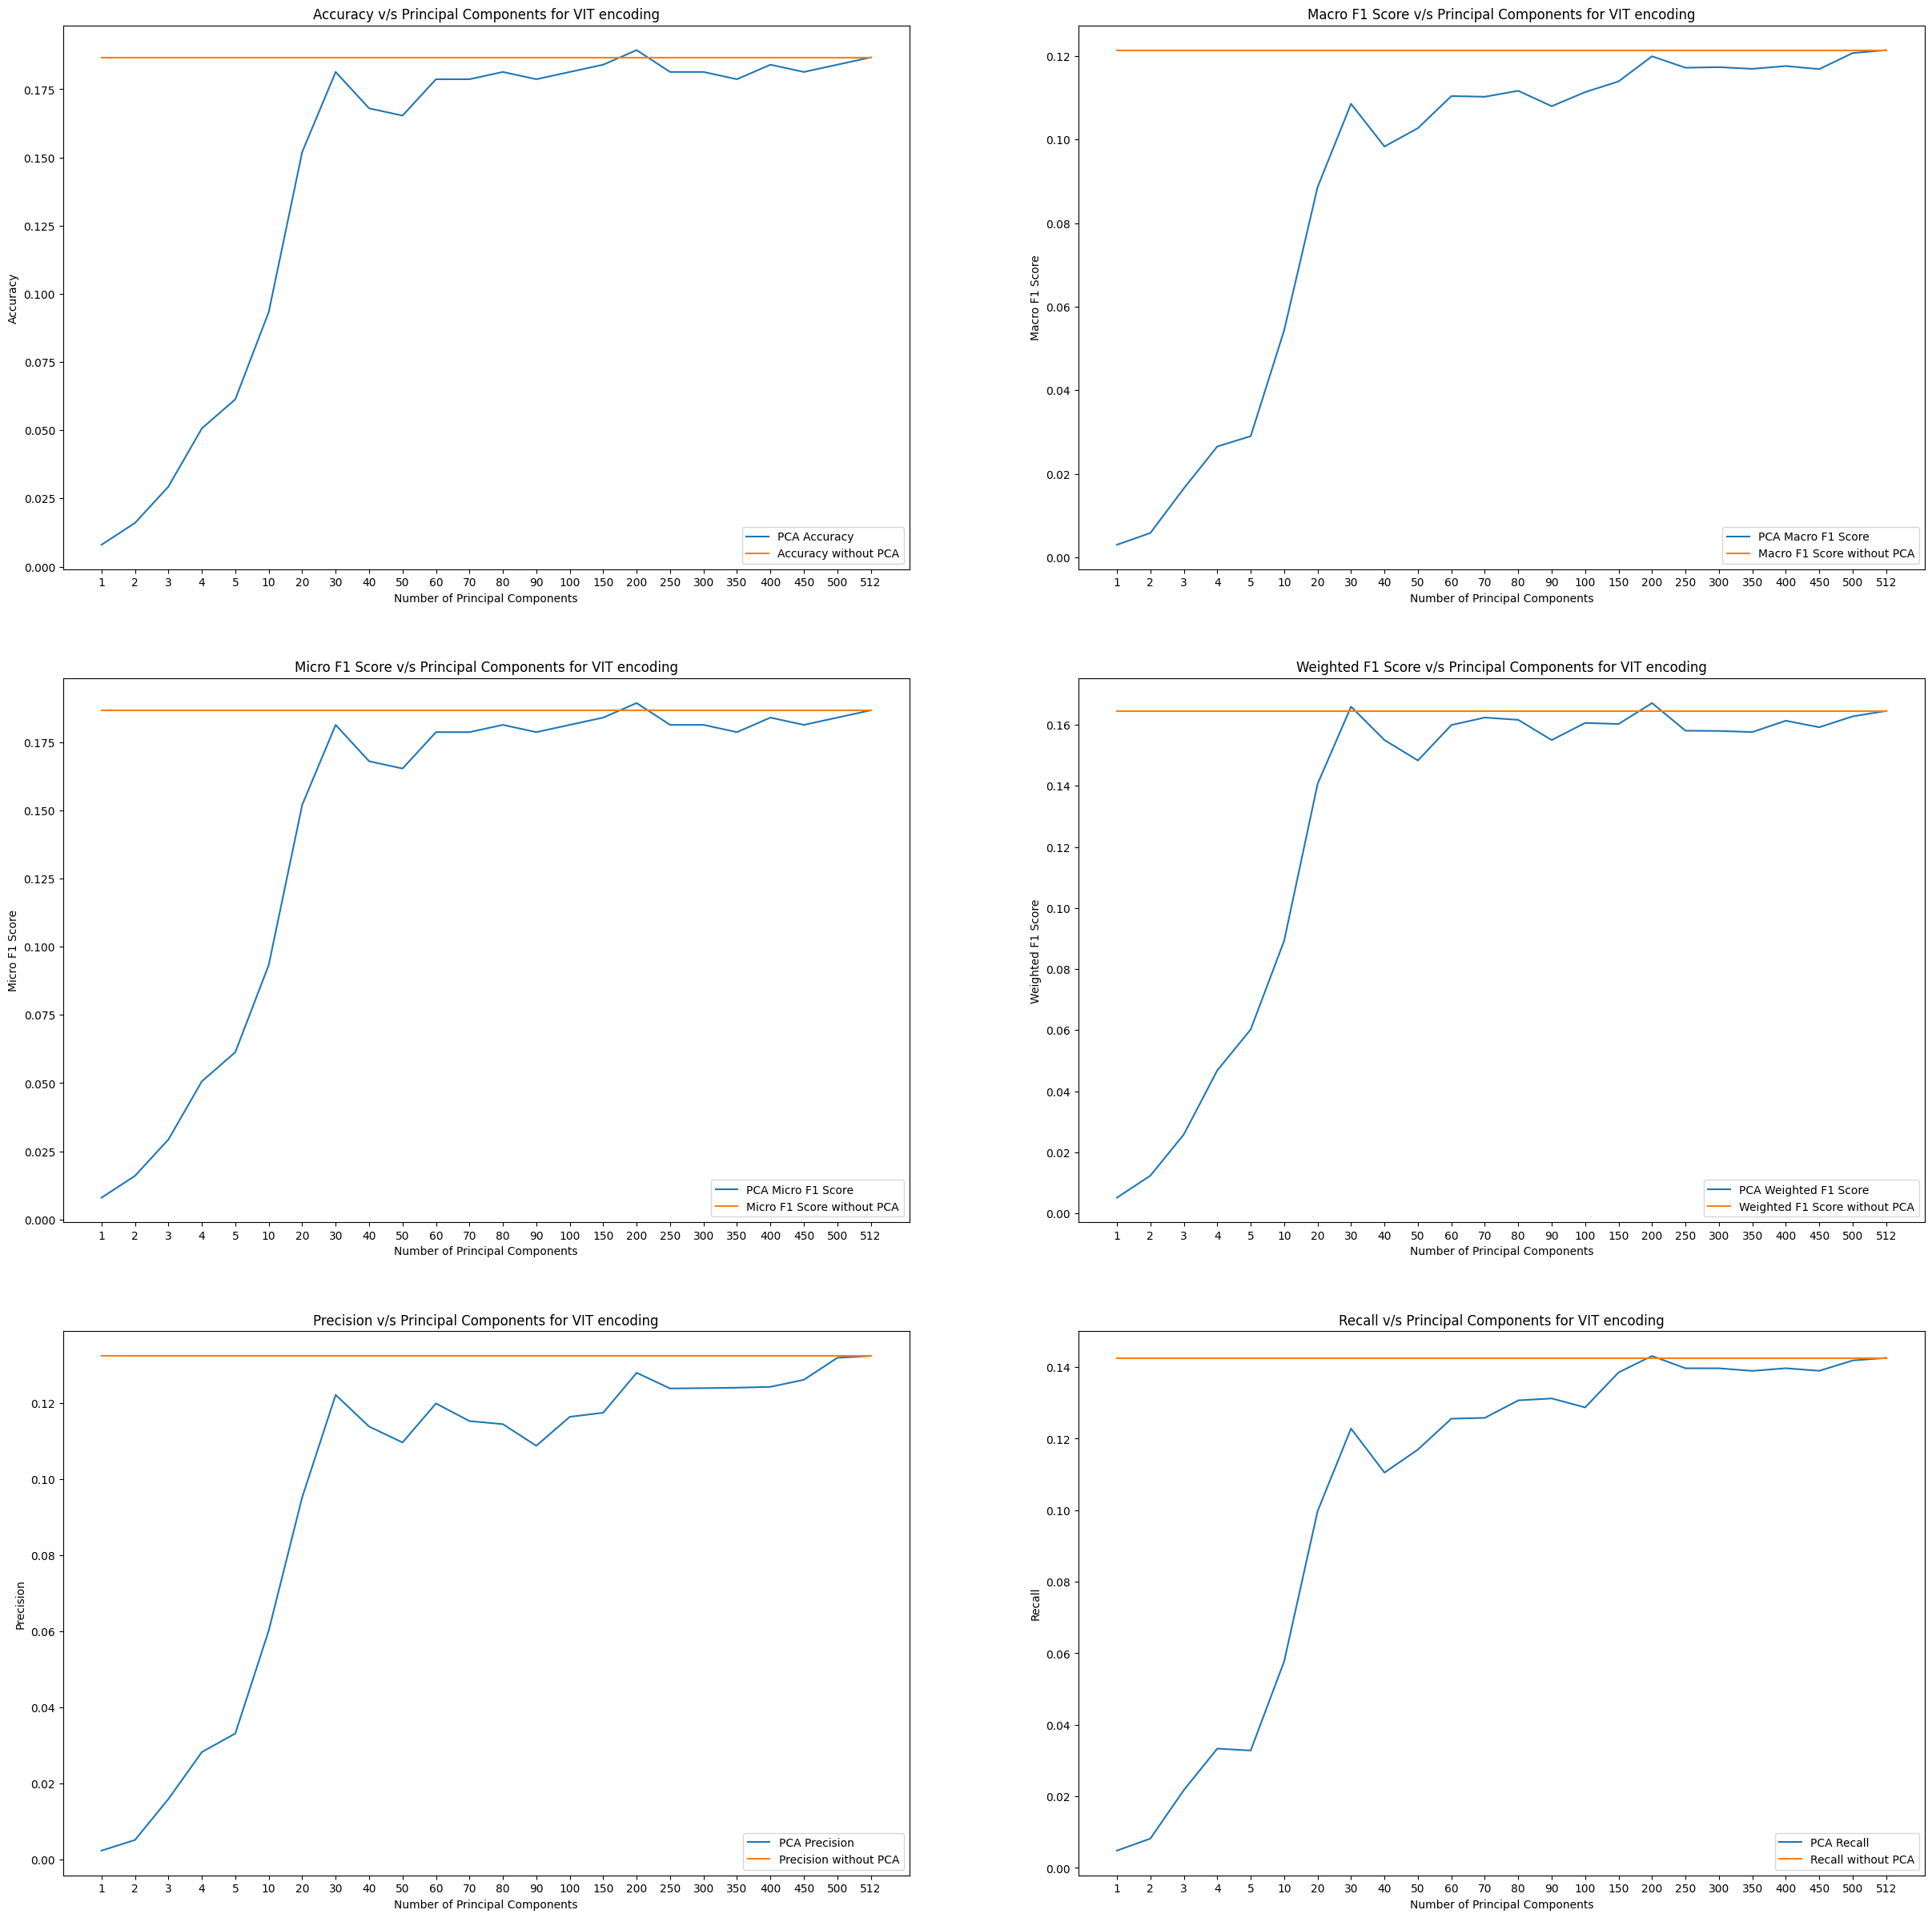

In [16]:
fig, axs = plt.subplots(3, 2, figsize=(30, 30))

axs[0, 0].plot([str(i) for i in num_features_VIT], np.array(VIT_pca_metrics)[:, 0], label='PCA Accuracy')
axs[0, 0].plot([str(i) for i in num_features_VIT], np.full(len(num_features_VIT), pre_PCA_accuracy_VIT), label='Accuracy without PCA')

axs[0, 1].plot([str(i) for i in num_features_VIT], np.array(VIT_pca_metrics)[:, 3], label='PCA Macro F1 Score')
axs[0, 1].plot([str(i) for i in num_features_VIT], np.full(len(num_features_VIT), pre_PCA_macro_f1_score_VIT), label='Macro F1 Score without PCA')

axs[1, 0].plot([str(i) for i in num_features_VIT], np.array(VIT_pca_metrics)[:, 4], label='PCA Micro F1 Score')
axs[1, 0].plot([str(i) for i in num_features_VIT], np.full(len(num_features_VIT), pre_PCA_micro_f1_score_VIT), label='Micro F1 Score without PCA')

axs[1, 1].plot([str(i) for i in num_features_VIT], np.array(VIT_pca_metrics)[:, 5], label='PCA Weighted F1 Score')
axs[1, 1].plot([str(i) for i in num_features_VIT], np.full(len(num_features_VIT), pre_PCA_weighted_f1_score_VIT), label='Weighted F1 Score without PCA')

axs[2, 0].plot([str(i) for i in num_features_VIT], np.array(VIT_pca_metrics)[:, 1], label='PCA Precision')
axs[2, 0].plot([str(i) for i in num_features_VIT], np.full(len(num_features_VIT), pre_PCA_precision_VIT), label='Precision without PCA')

axs[2, 1].plot([str(i) for i in num_features_VIT], np.array(VIT_pca_metrics)[:, 2], label='PCA Recall')
axs[2, 1].plot([str(i) for i in num_features_VIT], np.full(len(num_features_VIT), pre_PCA_recall_VIT), label='Recall without PCA')

metrics = ['Accuracy', 'Macro F1 Score', 'Micro F1 Score', 'Weighted F1 Score', 'Precision', 'Recall']
for i in range(3):
    for j in range(2):
        axs[i, j].set_xlabel('Number of Principal Components')
        axs[i, j].set_ylabel(metrics[i * 2 + j])
        axs[i, j].set_title(str(metrics[i * 2 + j]) + ' v/s Principal Components for VIT encoding')
        axs[i, j].legend()

plt.show()

- #### As we can observe, as we keep on increasing the number of features of the VIT encodings, the metrics get better and even become better than the values we obtain without performing PCA
- #### But as we further increase the number of components considered, PCA converges to the case of no PCA, as expected, because we are considering all the components to represent the image

### Problem 1.1.4 - Dimensionality reduction on IIIT-CFW dataset

#### Metrics of IIIT-CFW dataset without PCA

In [17]:
temp_CFW_dataset = np.reshape(X, (X.shape[0], -1))

pre_PCA_train_CFW = temp_CFW_dataset[:int(temp_CFW_dataset.shape[0] * opt['val_split']) ]
pre_PCA_test_CFW  = temp_CFW_dataset[ int(temp_CFW_dataset.shape[0] * opt['val_split']):]

PCA_train_labels_CFW = y[:int(y.shape[0] * opt['val_split']) ]
PCA_test_labels_CFW  = y[ int(y.shape[0] * opt['val_split']):]

# Chose k value of 100 as most of the images of the same person are 100 in number
pre_PCA_KNN_CFW = KNN_sk(n_neighbors=100)
pre_PCA_KNN_CFW.fit(pre_PCA_train_CFW, PCA_train_labels_CFW)

pre_PCA_predictions_CFW = pre_PCA_KNN_CFW.predict(pre_PCA_test_CFW)
pre_PCA_accuracy = sm.accuracy_score(PCA_test_labels_CFW, pre_PCA_predictions_CFW)

#### Metrics calculation after dimnesionality reduction using PCA

In [18]:
CFW_pca_accuracies = []

num_features_CFW = [1, 2, 3, 4, 5]
for i in range(10, 60, 10):
    num_features_CFW.append(i)
for i in range(100, 1000, 100):
    num_features_CFW.append(i)
num_features_CFW += [1000, 2000, 3000, 3072]

for i in num_features_CFW:
    CFW_PCA_Reducer = PCA()
    CFW_PCA_Reducer.fit(X)

    CFW_PCA_Reducer.set_num_principal_components(i)
    CFW_PCA_Reducer.transform()

    post_PCA_train_CFW = CFW_PCA_Reducer.X_transformed[:int(CFW_PCA_Reducer.X_transformed.shape[0] * opt['val_split']) ]
    post_PCA_test_CFW  = CFW_PCA_Reducer.X_transformed[ int(CFW_PCA_Reducer.X_transformed.shape[0] * opt['val_split']):]

    # Chose k value of 100 as most of the images of the same person are 100 in number
    post_PCA_KNN_CFW = KNN_sk(n_neighbors=100)
    post_PCA_KNN_CFW.fit(post_PCA_train_CFW, PCA_train_labels_CFW)

    post_PCA_predictions_CFW = post_PCA_KNN_CFW.predict(post_PCA_test_CFW)

    post_PCA_accuracy_CFW = sm.accuracy_score(PCA_test_labels_CFW, post_PCA_predictions_CFW)
    CFW_pca_accuracies.append(post_PCA_accuracy_CFW)

#### Comparision plots

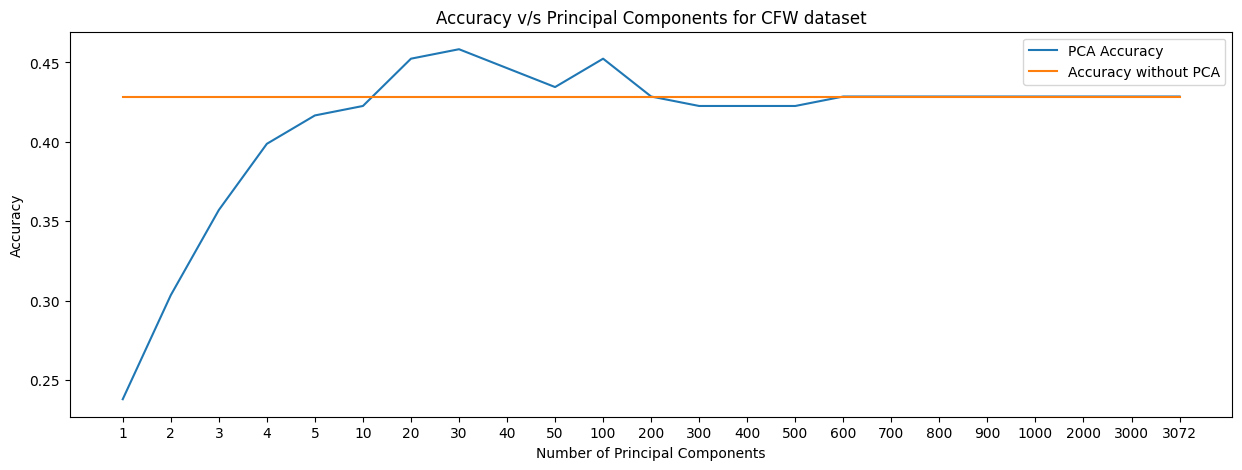

In [19]:
plt.figure(figsize=(15, 5))
plt.plot([str(i) for i in num_features_CFW], CFW_pca_accuracies, label='PCA Accuracy')
plt.plot([str(i) for i in num_features_CFW], np.full(len(num_features_CFW), pre_PCA_accuracy), label='Accuracy without PCA')
plt.xlabel('Number of Principal Components')
plt.ylabel('Accuracy')
plt.title('Accuracy v/s Principal Components for CFW dataset')
plt.legend()
plt.show()

- #### As we can observe, the trend is similar to the previous analysis on the Assignment 1 picitonary dataset, where it first increases and then slowly converges to those metrics of the analysis without PCA as we keep on increasing the number of features

## Problem 1.2 - PCA on Pictionary dataset

### Loading the data

In [20]:
drawer_df = pd.read_csv("./Data/PCA/Pictionary/drawer_attributes.csv")
# drawer_df = drawer_df.drop(columns=['d_drawer'])
drawer_data = drawer_df.to_numpy()

# display(drawer_df.style.hide(axis='index'))
display(drawer_df)

,d_drawer,d_area_median,d_stroke_freq_median,d_rangestroketime_median,d_firststroketime_median,d_laststroketime_median,d_pcgamestup,d_pcgamestdown,d_pcgameserasehighlight
0,10,0.000000,0.000000,0.000,0.000,0.000,0.000000,0.000000,0.000000
1,36,82306.749763,0.578802,21.660,3.512,26.815,0.000000,0.000000,0.777778
2,14,60929.328432,0.239168,25.087,1.368,26.455,1.000000,1.000000,1.000000
3,26,119037.637976,0.402533,54.162,2.459,56.621,0.750000,0.500000,1.000000
4,40,0.000000,0.000000,0.000,0.000,0.000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
95,489,70962.506524,0.545814,27.828,4.873,34.187,0.200000,0.000000,0.400000
96,476,44293.554261,0.214476,24.361,2.619,26.980,0.250000,0.000000,0.500000
97,491,28575.130088,0.281468,31.310,3.671,37.586,0.153846,0.076923,0.461538
98,504,49562.212555,0.172661,40.626,10.302,47.306,0.400000,0.200000,0.400000


### Problem 1.2.1 - Plotting features with respect to new PCA axes

#### PCA on Drawer features

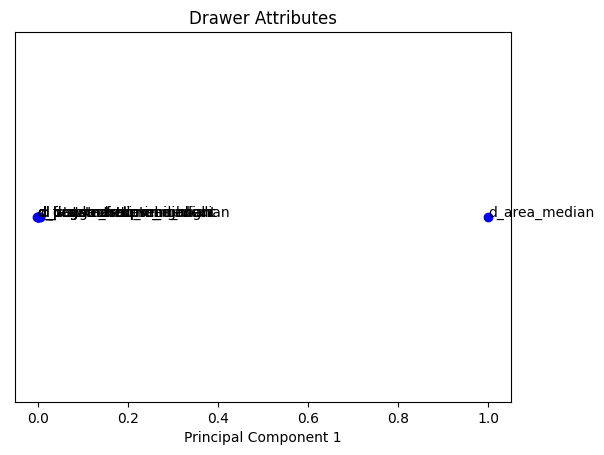

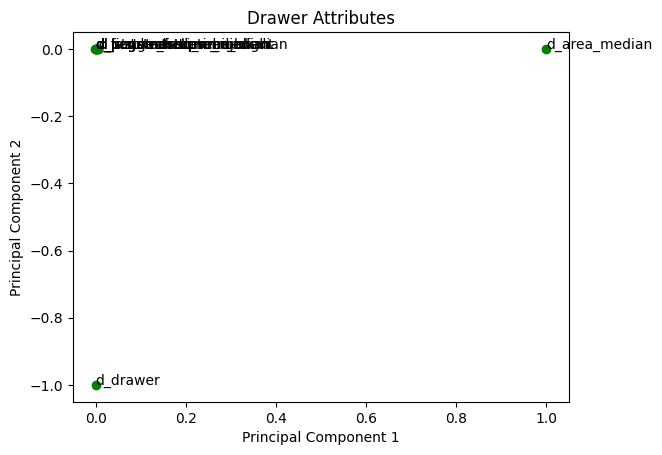

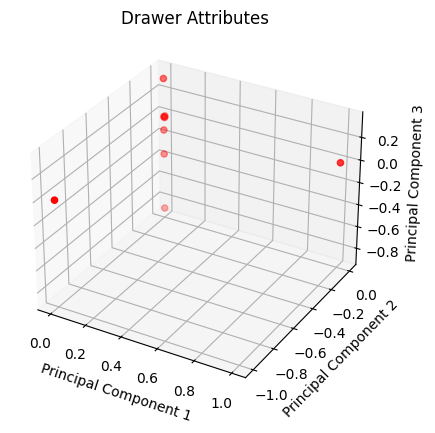

In [21]:
Drawer_PCA_Reducer = PCA()
Drawer_PCA_Reducer.fit(drawer_data)
drawer_feature_names = drawer_df.columns.values

# Features projected on PC1
plt.scatter(Drawer_PCA_Reducer.P[:, 0], np.zeros(Drawer_PCA_Reducer.P.shape[0]), color='blue')
for i, name in enumerate(drawer_feature_names):
    plt.annotate(name, (Drawer_PCA_Reducer.P[i, 0], 0))

plt.gca().axes.get_yaxis().set_visible(False)
plt.xlabel('Principal Component 1')
plt.title('Drawer Attributes')
plt.show()

# Features projected on PC2
Drawer_PCA_Reducer.set_num_principal_components(2)
Drawer_PCA_Reducer.transform()
plt.scatter(Drawer_PCA_Reducer.P[:, 0], Drawer_PCA_Reducer.P[:, 1], color='green')
for i, name in enumerate(drawer_feature_names):
    plt.annotate(name, (Drawer_PCA_Reducer.P[i, 0], Drawer_PCA_Reducer.P[i, 1]))

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Drawer Attributes')
plt.show()

# Features projected on PC3
Drawer_PCA_Reducer.set_num_principal_components(3)
Drawer_PCA_Reducer.transform()

ax = plt.figure().add_subplot(projection='3d')
ax.scatter(Drawer_PCA_Reducer.P[:, 0], Drawer_PCA_Reducer.P[:, 1], Drawer_PCA_Reducer.P[:, 2], color='red')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.title('Drawer Attributes')
plt.show()

projected_drawer_dataframe = pd.DataFrame(Drawer_PCA_Reducer.P[:, :3], columns=['Principal Component 1', 'Principal Component 2', 'Principal Component 3'])
fig = px.scatter_3d(projected_drawer_dataframe, x='Principal Component 1', y='Principal Component 2', z='Principal Component 3', title='Drawer Attributes')
fig.show()

- ##### As we can see above, the feature `d_area_median` is the first feature to be identfied as comparatively unrelated to the other features
- ##### Then comes the `d_drawer` feature, which is expected, as this feature represents the ID of the drawer, which is typically independent of the observations
- ##### All the other features still remain relatively together even after considering 3 PCA axes, as we can see that they fall on approximately a straight line

### Guesser data

In [22]:
guesser_df = pd.read_csv("./Data/PCA/Pictionary/guesser_attributes.csv")
# guesser_df = guesser_df.drop(columns=['g_guesser'])
guesser_data = guesser_df.to_numpy()

# display(guesser_df.style.hide(axis='index'))
display(guesser_df)

,g_guesser,g_noofmessage_median,g_firstmessagetime_median,g_lastmessagetime_median,g_rangemessagetime_median,g_pcgamesconfusion,g_entropy
0,10,0.0,0.000000,0.000000,0.000000,0.0,0.000000
1,36,1.0,25.367172,39.041594,0.000000,0.0,0.000000
2,14,2.0,12.988740,51.351317,38.362577,1.0,0.693147
3,26,3.5,20.622346,64.718058,44.095712,0.0,1.242453
4,40,3.0,30.339558,78.943003,48.603445,0.0,1.098612
...,...,...,...,...,...,...,...
95,489,3.0,10.652321,36.320770,10.546721,0.0,1.098612
96,476,1.5,10.728426,37.334943,26.606517,0.0,0.346574
97,491,2.0,31.399657,45.160252,9.038865,0.0,0.693147
98,504,1.5,24.975650,48.008175,21.551010,0.0,0.346574


#### PCA on Guesser features

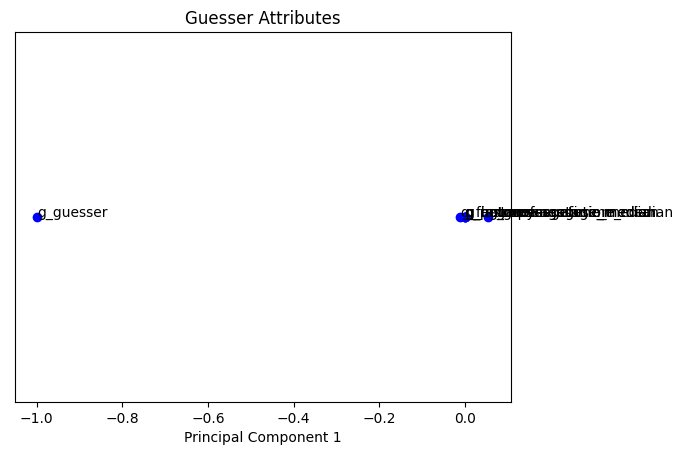

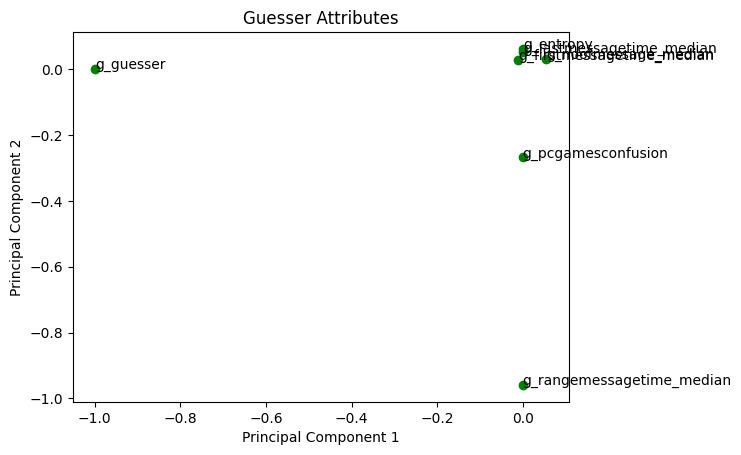

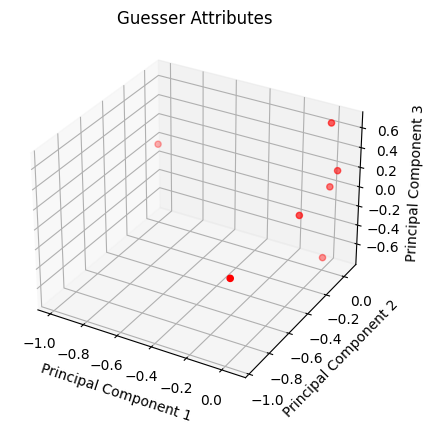

In [23]:
Guesser_PCA_Reducer = PCA()
Guesser_PCA_Reducer.fit(guesser_data)
guesser_feature_names = guesser_df.columns.values

# Features projected on PC1
Guesser_PCA_Reducer.set_num_principal_components(1)
Guesser_PCA_Reducer.transform()
plt.scatter(Guesser_PCA_Reducer.P[:, 0], np.zeros(Guesser_PCA_Reducer.P.shape[0]), color='blue')
for i, name in enumerate(guesser_feature_names):
    plt.annotate(name, (Guesser_PCA_Reducer.P[i, 0], 0))

plt.gca().axes.get_yaxis().set_visible(False)
plt.xlabel('Principal Component 1')
plt.title('Guesser Attributes')
plt.show()

# Features projected on PC2
Guesser_PCA_Reducer.set_num_principal_components(2)
Guesser_PCA_Reducer.transform()
plt.scatter(Guesser_PCA_Reducer.P[:, 0], Guesser_PCA_Reducer.P[:, 1], color='green')
for i, name in enumerate(guesser_feature_names):
    plt.annotate(name, (Guesser_PCA_Reducer.P[i, 0], Guesser_PCA_Reducer.P[i, 1]))

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Guesser Attributes')
plt.show()

# Features projected on PC3
Guesser_PCA_Reducer.set_num_principal_components(3)
Guesser_PCA_Reducer.transform()

ax = plt.figure().add_subplot(projection='3d')
ax.scatter(Guesser_PCA_Reducer.P[:, 0], Guesser_PCA_Reducer.P[:, 1], Guesser_PCA_Reducer.P[:, 2], color='red')

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.title('Guesser Attributes')
plt.show()

projected_guesser_dataframe = pd.DataFrame(Guesser_PCA_Reducer.P[:, :3], columns=['Principal Component 1', 'Principal Component 2', 'Principal Component 3'])
fig = px.scatter_3d(projected_guesser_dataframe, x='Principal Component 1', y='Principal Component 2', z='Principal Component 3', title='Guesser Attributes')
fig.show()

- ##### As we can see above, the feature `g_guesser` is the first feature to be identfied as comparatively unrelated to the other features, which is expected, as this feature represents the ID of the guesser, which is typically independent of the observations
- ##### When projected onto the second PCA axis, we can see that the features `g_pcgamesconfusion`, which represents the percentage of games played with confusion, and `g_rangemessagetime_median`, which represents the duration between the first and last guess separate out from the rest of the features, as the information they provide is mostly unrelated to that information which is given by the other features like `g_entropy` and the others

### Problem 1.2.2 - Significance of the axes obtained from PCA

- #### The axes of PCA generally are used to infer the direction of the spread of data
- #### Hence, PC1, which is the axis representing the first principal component, denotes the direction along which there is maximum spread of data and along this direction, most of the variation (variance) of the data can be explained
- #### Next, PC2, as can be inferred represents the axis along which there is next highest spread of data. This is perpendicular to PC1, which if it is not, some component of the variation can again be explained using PC1. So, it is perpendicular to PC1
- #### Similarly, all further axes such as PC3, PC4 and so on are perpendicular to all previous principal component axes and represent the axes along which there is next highest spread of data